# Minimal Cost-Complexity Pruning for Regression Problems

### Imports and data loading

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import balanced_accuracy_score
from sklearn.datasets import load_boston

%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "darkgrid") 

# Seed for reproducibility
np.random.seed(88)

# Data loading: we use a simple toy dataset
X, y = load_boston(return_X_y = True)

# Data partitioning
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = .25)

###  Mininal cost-complexity pruning

In [2]:
# Data partitioning
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = .25)

<IPython.core.display.Javascript object>


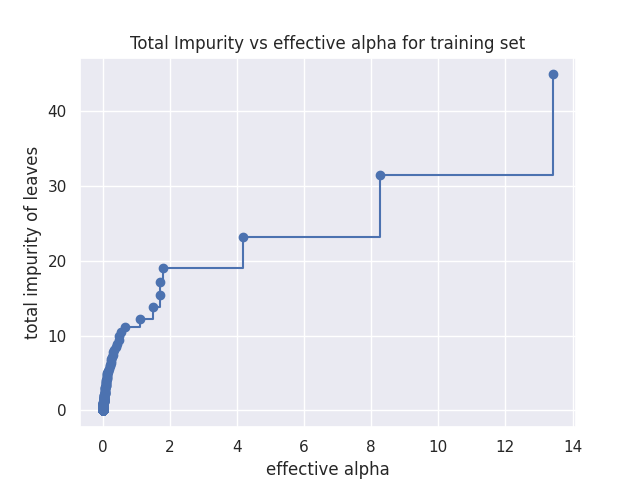

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

In [9]:
# Getting sequence of ccp_alphas values to post pruning decision tree with cost complexity tuning
clf = DecisionTreeRegressor(random_state = 0) 
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Plotting  Total Impurity vs effective alpha for training data
plt.figure()
plt.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
plt.xlabel("effective alpha")
plt.ylabel("total impurity of leaves")
plt.title("Total Impurity vs effective alpha for training set")

It seems reasonable consider values greater then 0.6

<IPython.core.display.Javascript object>


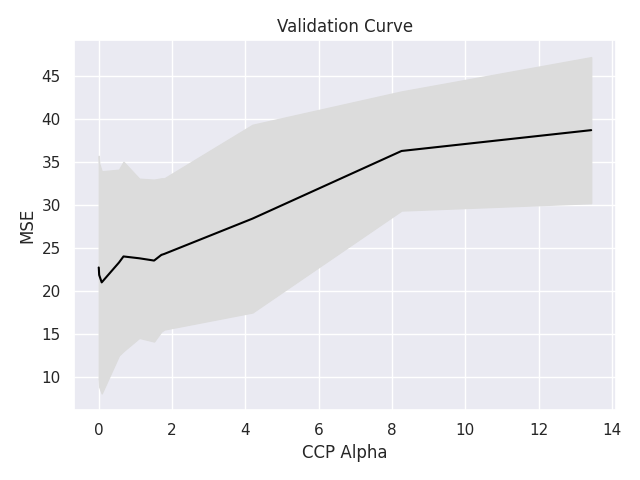

In [10]:
# Auxiliary function
def inner_loop(X_train_in, y_train_in, X_val_in, y_val_in, ccp_alpha):
    """Compute balanced classification accuracy for a given split and ccp_alpha value"""

    clf = DecisionTreeRegressor(random_state = 0, 
                                 ccp_alpha = ccp_alpha)
    clf.fit(X_train_in, y_train_in)
    y_hat = clf.predict(X_val_in)
    MSE = np.mean((y_val_in  - y_hat) ** 2)

    return MSE

# Preparing the grid of ccp_alphas values
alpha_th = 0.6
ccp_alphas = ccp_alphas[1:-1]
ccp_alphas2 = ccp_alphas[ccp_alphas > alpha_th]
ccp_alphas1 = ccp_alphas[ccp_alphas <= alpha_th]
ccp_alphas1 = np.logspace(np.log10(ccp_alphas1[0]), np.log10(ccp_alphas1[-1]), num = 20)
ccp_alphas_ = np.hstack([ccp_alphas1, ccp_alphas2])

# Divide training data in 10 folds to choose best ccp_alpha value by CV
skf = StratifiedKFold(n_splits = 10, random_state = 0, shuffle = True)
skf = KFold(n_splits=5, shuffle = True, random_state = 0)
skf.get_n_splits(X_train, y_train)

# Cross-validation
scores_out = []
for train_index, val_index in skf.split(X_train, y_train):

    X_train_in = X_train[train_index]
    y_train_in = y_train[train_index]

    X_val_in = X_train[val_index]
    y_val_in = y_train[val_index]

    scores_in = [inner_loop(X_train_in, y_train_in, X_val_in, y_val_in, ccp_alpha) for ccp_alpha in ccp_alphas_]
    scores_out.append(scores_in)

# Computing CV accuracies
cv_perf = np.array(scores_out).mean(axis = 0)
cv_perf_std = np.array(scores_out).std(axis = 0)

# Plotting validation curve
plt.figure()
plt.plot(ccp_alphas_, cv_perf, label="Cross-validation score", color="black")
plt.fill_between(ccp_alphas_, cv_perf - cv_perf_std, cv_perf + cv_perf_std, color="gainsboro")

plt.title("Validation Curve")
plt.xlabel("CCP Alpha")
plt.ylabel("MSE")
plt.tight_layout()

I have selected the ccp_alpha value which provides the lowest (balanced) CV average MSE (a deeper analysis should also consider the standard deviation and eventually model complexity ).

### Model selection and final model training

In [5]:
# Retrieving best ccp_alpha values
best = np.argmin(cv_perf) 
best_ccp_alpha = ccp_alphas_[best] 

# Retraining model with all training data and using best ccp_alpha value
clf_best = DecisionTreeRegressor(random_state = 0, 
                                  ccp_alpha = best_ccp_alpha)
clf_best.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.08056378264193494, random_state=0)

### Model assessment

In [6]:
# Prediction on test set after pruning by CV
y_hat_test = clf_best.predict(X_test)
test_perf = np.mean((y_test - y_hat_test) ** 2)
print(test_perf)

# Prediction on test set without pruning
clf.fit(X_train, y_train)
y_hat_test = clf.predict(X_test)
test_perf = np.mean((y_test - y_hat_test) ** 2)
print(test_perf)

26.656889534532663
27.977480314960626


### Feature Importance

In [11]:
clf_best.feature_importances_ > 0

array([ True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True])